In [1]:
import pandas as pd
 
input_book = pd.ExcelFile('/home/brain/Downloads/心理検査DB_差分入り.xlsx')
input_exc = pd.ExcelFile('/home/brain/Downloads/Synapsology.運動習慣.xlsx')
result_lh_df = pd.read_table("/home/brain/Downloads/lh.thick.spc.csv", delim_whitespace=True)
result_rh_df = pd.read_table("/home/brain/Downloads/rh.thick.spc.csv", delim_whitespace=True)

#sheet_namesメソッドでExcelブック内の各シートの名前をリストで取得できる
input_sheet_name = input_book.sheet_names
exc_sheet_name = input_exc.sheet_names

#DataFrameとして一つ目のsheetを読込
exc_sheet_df = input_exc.parse(exc_sheet_name[0])
exc_sheet_df=exc_sheet_df.drop(exc_sheet_df.columns[[2,3,4]],axis=1)
exc_sheet_df.loc[(exc_sheet_df[exc_sheet_df.columns[2]] == 0), exc_sheet_df.columns[2]] = 0
exc_sheet_df.loc[(exc_sheet_df[exc_sheet_df.columns[2]] > 0) & (exc_sheet_df[exc_sheet_df.columns[2]] < 5), exc_sheet_df.columns[2]] = 1
exc_sheet_df.loc[(exc_sheet_df[exc_sheet_df.columns[2]] >= 5), exc_sheet_df.columns[2]] = 2

In [2]:
#DataFrameとして一つ目のsheetを読込
fu_sheet_df = input_book.parse(input_sheet_name[0])
fu_sheet_df=fu_sheet_df[fu_sheet_df[fu_sheet_df.columns[0]].str.contains("",na=False)]

#読み込んだシート名の確認
print("Sheet name:", input_sheet_name[0])

fu_sheet_df=fu_sheet_df.iloc[:,0:24]
fu_sheet_df=fu_sheet_df.drop(fu_sheet_df.columns[[21,22]],axis=1)
#読み込んだシートの先頭5行を表示
print(fu_sheet_df.shape)#head(5))

Sheet name: follow_without29
(51, 22)


In [3]:
#DataFrameとして3つ目のsheetを読込（グラフはsheetとしてカウントされない？）
bl_sheet_df = input_book.parse(input_sheet_name[1])
bl_sheet_df=bl_sheet_df[bl_sheet_df[bl_sheet_df.columns[0]].str.contains("",na=False)]

#読み込んだシート名の確認
print("Sheet name:", input_sheet_name[1])

bl_sheet_df=bl_sheet_df.drop(bl_sheet_df.columns[[21,23,27,28]],axis=1)
#読み込んだシートの先頭5行を表示
print(bl_sheet_df.shape)#head(5))

Sheet name: baseline_without29
(51, 29)


In [4]:
bl_fu_sheet_df=pd.merge(bl_sheet_df, fu_sheet_df, left_on=bl_sheet_df.columns[0], right_on=fu_sheet_df.columns[0], how="inner", suffixes = ["_bl", "_fu"])
bl_fu_sheet_df.columns=bl_fu_sheet_df.columns.str.replace(" ","_")
bl_fu_sheet_df.columns=bl_fu_sheet_df.columns.str.replace("\n","_")
bl_fu_sheet_df=pd.merge(exc_sheet_df, bl_fu_sheet_df, left_on=exc_sheet_df.columns[0], right_on=bl_fu_sheet_df.columns[0], how="inner", suffixes = ["_exc", ""])
print(bl_fu_sheet_df.shape)#head(5))

(51, 52)


In [5]:
#print(result_lh_df.head(5))
#print(result_rh_df.head(5))
bl_fu_bilateral_df=pd.merge(result_lh_df, result_rh_df, left_on=result_lh_df.columns[0], right_on=result_rh_df.columns[0], how="inner", suffixes = ["_lh", "_rh"])
print(bl_fu_bilateral_df.shape)#head(5))

(50, 75)


In [6]:
df_result=pd.merge(bl_fu_sheet_df, bl_fu_bilateral_df, left_on=bl_fu_sheet_df.columns[0], right_on=bl_fu_bilateral_df.columns[0], how="inner").sort_values(by=bl_fu_sheet_df.columns[0])
print(df_result.shape)
#print(df_result)
print(type(df_result))

(50, 127)
<class 'pandas.core.frame.DataFrame'>


In [7]:
df_result=df_result.T.drop_duplicates().T # 重複列削除
df_result=df_result.set_index("研究ID")
print(df_result.shape)
print(type(df_result))
df_result.to_csv('/home/brain/Downloads/spc_df_result.csv')
df_result = pd.read_csv('/home/brain/Downloads/spc_df_result.csv')
df_result=df_result.set_index("研究ID")
df_result=df_result.drop(columns=["検査日_bl", "検査日_fu", "年齢_fu"])
print(df_result.shape)
print(type(df_result))

(50, 120)
<class 'pandas.core.frame.DataFrame'>
(50, 117)
<class 'pandas.core.frame.DataFrame'>


                                     spc      pval
15              lh_paracentral_thickness  0.016735
10     lh_lateralorbitofrontal_thickness  0.104010
21       lh_posteriorcingulate_thickness  0.193683
37  rh_caudalanteriorcingulate_thickness  0.195481
38      rh_caudalmiddlefrontal_thickness  0.204341
..                                   ...       ...
12      lh_medialorbitofrontal_thickness  0.905841
5                  lh_fusiform_thickness  0.906258
41                 rh_fusiform_thickness  0.912247
70            rh_MeanThickness_thickness  0.919063
25     lh_rostralmiddlefrontal_thickness  0.979411

[71 rows x 2 columns]


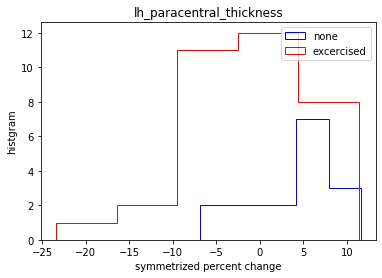

In [8]:
from scipy import stats

ttest_result_df = pd.DataFrame(index=[], columns=['spc', 'pval'])
for ii in range(df_result.columns.get_loc('lh_bankssts_thickness'),df_result.columns.get_loc('rh_MeanThickness_thickness')+1):
    ttest_A=df_result.loc[(df_result['運動習慣'] == 0),df_result.columns[ii]]
    ttest_B=df_result.loc[(df_result['運動習慣'] == 1),df_result.columns[ii]]
#    print(ttest_A.shape, ttest_A.head(5))
#    print(ttest_B.shape, ttest_B.head(5))
    ttest_result=stats.ttest_ind(ttest_A,ttest_B)
    #ttest_result=stats.ttest_rel(ttest_A,ttest_B)
    ttest_result_df=ttest_result_df.append(pd.DataFrame([[df_result.columns[ii],ttest_result.pvalue]], columns=ttest_result_df.columns),ignore_index=True)
print(ttest_result_df.sort_values('pval'))
#
import matplotlib.pyplot as plt
minspcname=ttest_result_df.sort_values('pval')['spc'].reset_index(drop=True)[0]
ttest_A=df_result.loc[(df_result['運動習慣'] == 0),minspcname]
ttest_B=df_result.loc[(df_result['運動習慣'] == 1),minspcname]
plt.hist(ttest_A, bins=5, histtype="step", color="b", label="none")
plt.hist(ttest_B, bins=5, histtype="step", color="r", label="excercised")
plt.title(minspcname)
plt.xlabel("symmetrized percent change")
plt.ylabel("histgram")
plt.legend()
plt.savefig('figure.png')

In [9]:
from statsmodels.formula.api import ols

df_result['n運動習慣'] = 0
df_result.loc[(df_result['運動習慣'] == 0),'n運動習慣'] = 1

ftest_result_df = pd.DataFrame(index=[], columns=['spc', 'pval'])
for ii in range(df_result.columns.get_loc('lh_bankssts_thickness'),df_result.columns.get_loc('rh_MeanThickness_thickness')+1):
    ftest_A=df_result.loc[:,['年齢_bl','運動習慣','n運動習慣',df_result.columns[ii]]]
    #print(ftest_A.head())
    model=ols(df_result.columns[ii]+' ~ 運動習慣 + n運動習慣 + 年齢_bl', ftest_A).fit()
    #print(model.summary())
    ftest_result=model.f_test([0, 1, -1, 0])
    ftest_result_df=ftest_result_df.append(pd.DataFrame([[df_result.columns[ii],ftest_result.pvalue]], columns=ttest_result_df.columns),ignore_index=True)
print(ftest_result_df.sort_values('pval'))

                                     spc                 pval
15              lh_paracentral_thickness  0.06521633186678681
10     lh_lateralorbitofrontal_thickness  0.06855451178118446
13           lh_middletemporal_thickness  0.12322331736738659
37  rh_caudalanteriorcingulate_thickness   0.1504070320466169
19            lh_pericalcarine_thickness  0.16370644546916785
..                                   ...                  ...
39                   rh_cuneus_thickness    0.916392092924125
28         lh_superiortemporal_thickness   0.9252731407596322
67             rh_temporalpole_thickness   0.9324047385057815
61     rh_rostralmiddlefrontal_thickness    0.933111995020979
32       lh_transversetemporal_thickness   0.9539083771565285

[71 rows x 2 columns]


                                  spc      pval
43      rh_inferiortemporal_thickness  0.024123
15           lh_paracentral_thickness  0.043379
68    rh_transversetemporal_thickness  0.045278
59             rh_precuneus_thickness  0.081817
63      rh_superiorparietal_thickness  0.085495
..                                ...       ...
48   rh_medialorbitofrontal_thickness  0.906486
34         lh_MeanThickness_thickness  0.926320
25  lh_rostralmiddlefrontal_thickness  0.953235
6       lh_inferiorparietal_thickness  0.963000
41              rh_fusiform_thickness  0.988833

[71 rows x 2 columns]
                                 spc group      pval
129    rh_inferiortemporal_thickness  high  0.017877
46          lh_paracentral_thickness   low  0.038581
206  rh_transversetemporal_thickness  none  0.041049
178           rh_precuneus_thickness   low  0.081452
201        rh_temporalpole_thickness  high  0.086483
..                               ...   ...       ...
99               lh_insula_thi

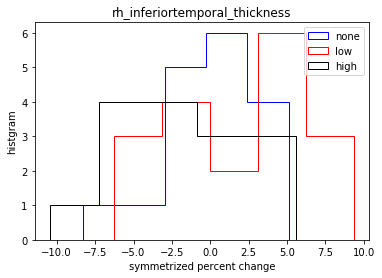

In [10]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

ftest_result_df = pd.DataFrame(index=[], columns=['spc', 'pval'])
tktest_result_df = pd.DataFrame(index=[], columns=['spc', 'group', 'pval'])
for ii in range(df_result.columns.get_loc('lh_bankssts_thickness'),df_result.columns.get_loc('rh_MeanThickness_thickness')+1):
    # f test
    ftest_A=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 0),df_result.columns[ii]]
    ftest_B=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 1),df_result.columns[ii]]
    ftest_C=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 2),df_result.columns[ii]]
    ftest_result=stats.f_oneway(ftest_A,ftest_B,ftest_C)
    ftest_result_df=ftest_result_df.append(pd.DataFrame([[df_result.columns[ii],ftest_result.pvalue]], columns=ftest_result_df.columns),ignore_index=True)
    # tukey test
    ftest_ABC=pd.concat([ftest_A, ftest_B, ftest_C])
    ftest_I=['none' for _ in range(ftest_A.shape[0])]+['low' for _ in range(ftest_B.shape[0])]+['high' for _ in range(ftest_C.shape[0])]
    temptkresult=vars(pairwise_tukeyhsd(ftest_ABC, ftest_I))
    tktest_result_df=tktest_result_df.append(pd.DataFrame([[df_result.columns[ii], temptkresult['groupsunique'][0], temptkresult['pvalues'][0]]], columns=tktest_result_df.columns),ignore_index=True)
    tktest_result_df=tktest_result_df.append(pd.DataFrame([[df_result.columns[ii], temptkresult['groupsunique'][1], temptkresult['pvalues'][1]]], columns=tktest_result_df.columns),ignore_index=True)
    tktest_result_df=tktest_result_df.append(pd.DataFrame([[df_result.columns[ii], temptkresult['groupsunique'][2], temptkresult['pvalues'][2]]], columns=tktest_result_df.columns),ignore_index=True)
print(ftest_result_df.sort_values('pval'))
print(tktest_result_df.sort_values('pval'))
#
#import matplotlib.pyplot as plt
minspcname=ftest_result_df.sort_values('pval')['spc'].reset_index(drop=True)[0]
ftest_A=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 0),minspcname]
ftest_B=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 1),minspcname]
ftest_C=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 2),minspcname]
plt.hist(ftest_A, bins=5, histtype="step", color="b", label="none")
plt.hist(ftest_B, bins=5, histtype="step", color="r", label="low")
plt.hist(ftest_C, bins=5, histtype="step", color="k", label="high")
plt.title(minspcname)
plt.xlabel("symmetrized percent change")
plt.ylabel("histgram")
plt.legend()
plt.savefig('f_figure.png')

In [11]:
from statsmodels.formula.api import ols

df_result['n運動習慣'] = 0
df_result['l運動習慣'] = 0
df_result['h運動習慣'] = 0
df_result.loc[(df_result['運動習慣_あり_運動時間'] == 0),'n運動習慣'] = 1
df_result.loc[(df_result['運動習慣_あり_運動時間'] == 1),'l運動習慣'] = 1
df_result.loc[(df_result['運動習慣_あり_運動時間'] == 2),'h運動習慣'] = 1
#print(df_result.head())
ftest_result_df = pd.DataFrame(index=[], columns=['spc', 'pval'])
for ii in range(df_result.columns.get_loc('lh_bankssts_thickness'),df_result.columns.get_loc('rh_MeanThickness_thickness')+1):
    ftest_A=df_result.loc[:,['年齢_bl','n運動習慣','l運動習慣','h運動習慣',df_result.columns[ii]]]
    #print(ftest_A.head())
    model=ols(df_result.columns[ii]+' ~ n運動習慣 + l運動習慣 + h運動習慣 + 年齢_bl', ftest_A).fit()
    #print(model.summary())
    ftest_result=model.f_test([0, 1, -0.5, -0.5, 0])
    ftest_result_df=ftest_result_df.append(pd.DataFrame([[df_result.columns[ii]+"_n",ftest_result.pvalue]], columns=ttest_result_df.columns),ignore_index=True)
    ftest_result=model.f_test([0, -0.5, 1, -0.5, 0])
    ftest_result_df=ftest_result_df.append(pd.DataFrame([[df_result.columns[ii]+"_l",ftest_result.pvalue]], columns=ttest_result_df.columns),ignore_index=True)
    ftest_result=model.f_test([0, -0.5, -0.5, 1, 0])
    ftest_result_df=ftest_result_df.append(pd.DataFrame([[df_result.columns[ii]+"_h",ftest_result.pvalue]], columns=ttest_result_df.columns),ignore_index=True)
print(ftest_result_df.sort_values('pval'))

                                    spc                  pval
131     rh_inferiortemporal_thickness_h  0.015599115181670826
205   rh_transversetemporal_thickness_l  0.021988665471894278
130     rh_inferiortemporal_thickness_l  0.025497333368157363
169          rh_postcentral_thickness_l   0.04678270347094036
115  rh_caudalmiddlefrontal_thickness_l   0.06087511445106345
..                                  ...                   ...
123             rh_fusiform_thickness_n    0.9816348233011339
145  rh_medialorbitofrontal_thickness_l    0.9863088650911775
55      lh_parstriangularis_thickness_l    0.9902386417230964
27      lh_lateraloccipital_thickness_n    0.9962731583390426
210        rh_MeanThickness_thickness_n    0.9987226288433456

[213 rows x 2 columns]


In [12]:
# different slope
df_result['n年齢_bl'] = 0
df_result['l年齢_bl'] = 0
df_result['h年齢_bl'] = 0
df_result.loc[(df_result['運動習慣_あり_運動時間'] == 0),'n年齢_bl'] = df_result['年齢_bl']
df_result.loc[(df_result['運動習慣_あり_運動時間'] == 1),'l年齢_bl'] = df_result['年齢_bl']
df_result.loc[(df_result['運動習慣_あり_運動時間'] == 2),'h年齢_bl'] = df_result['年齢_bl']
#print(df_result.head())
ftest_result_df = pd.DataFrame(index=[], columns=['spc', 'pval'])
for ii in range(df_result.columns.get_loc('lh_bankssts_thickness'),df_result.columns.get_loc('rh_MeanThickness_thickness')+1):
    ftest_A=df_result.loc[:,['n運動習慣','l運動習慣','h運動習慣','n年齢_bl','l年齢_bl','h年齢_bl',df_result.columns[ii]]]
    #print(ftest_A.head())
    model=ols(df_result.columns[ii]+' ~ n運動習慣 + l運動習慣 + h運動習慣 + n年齢_bl + l年齢_bl + h年齢_bl', ftest_A).fit()
    #print(model.summary())
#    ftest_result=model.f_test([0, 1, -0.5, -0.5, 0, 0, 0])
    ftest_result=model.f_test([0, 0, 0, 0, 1, -0.5, -0.5])
    ftest_result_df=ftest_result_df.append(pd.DataFrame([[df_result.columns[ii]+"_n",ftest_result.pvalue]], columns=ttest_result_df.columns),ignore_index=True)
#    ftest_result=model.f_test([0, -0.5, 1, -0.5, 0, 0, 0])
    ftest_result=model.f_test([0, 0, 0, 0, -0.5, 1, -0.5])
    ftest_result_df=ftest_result_df.append(pd.DataFrame([[df_result.columns[ii]+"_l",ftest_result.pvalue]], columns=ttest_result_df.columns),ignore_index=True)
#    ftest_result=model.f_test([0, -0.5, -0.5, 1, 0, 0, 0])
    ftest_result=model.f_test([0, 0, 0, 0, -0.5, -0.5, 1])
    ftest_result_df=ftest_result_df.append(pd.DataFrame([[df_result.columns[ii]+"_h",ftest_result.pvalue]], columns=ttest_result_df.columns),ignore_index=True)
print(ftest_result_df.sort_values('pval'))

                                        spc                   pval
117                   rh_cuneus_thickness_n  0.0012882107850968726
119                   rh_cuneus_thickness_h   0.009731104083594313
21          lh_inferiortemporal_thickness_n   0.012235678714198863
105                 BrainSegVolNotVent_lh_n   0.029676870020280497
179                rh_precuneus_thickness_h   0.029767659577479687
..                                      ...                    ...
59             lh_pericalcarine_thickness_h     0.9812955885023223
5    lh_caudalanteriorcingulate_thickness_h     0.9828928638309783
70                 lh_precuneus_thickness_l     0.9878373627829853
46               lh_paracentral_thickness_l     0.9883866043788294
17                  lh_fusiform_thickness_h     0.9945383005527954

[213 rows x 2 columns]


In [13]:
#print(df_result)
corr_matp = df_result.corr(method='pearson')
#print(corr_matp)
corr_matp=corr_matp.dropna(how = 'all')
corr_matp=corr_matp.dropna(axis = 'columns')
corr_matp.to_csv('/home/brain/Downloads/spc_corr_matp.csv')

/home/brain/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 36939 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/brain/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21205 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/brain/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 32722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/brain/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 24931 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/brain/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/brain/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: 

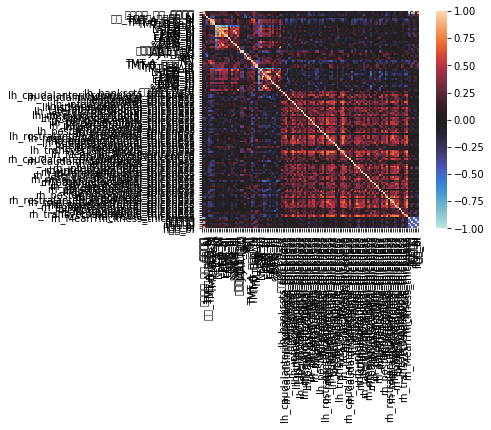

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(corr_matp,square=True,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=False, # True:格子の中に値を表示
#            fmt='.1f',
            xticklabels=corr_matp.columns.values,
            yticklabels=corr_matp.columns.values
           )
plt.show()
#fig = plt.figure(figsize=(10,10),dpi=200)
#fig.show()

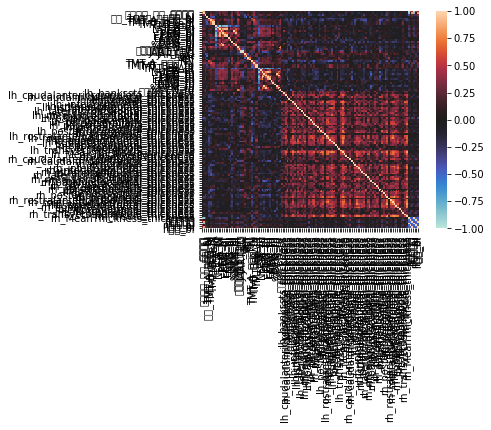

In [15]:
corr_mats = df_result.corr(method='spearman')
corr_mats=corr_mats.dropna(how = 'all')
corr_mats=corr_mats.dropna(axis = 'columns')
corr_mats.to_csv('/home/brain/Downloads/spc_corr_mats.csv')
sns.heatmap(corr_mats,square=True,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=False, # True:格子の中に値を表示
#            fmt='.1f',
            xticklabels=corr_mats.columns.values,
            yticklabels=corr_mats.columns.values
           )
plt.show()

In [16]:
print(corr_matp)

                     運動習慣  運動習慣_あり_運動時間     年齢_bl  性別_1：男性_２：女性_bl  \
運動習慣             1.000000      0.824224  0.305159        -0.065492   
運動習慣_あり_運動時間     0.824224      1.000000  0.398168        -0.158406   
年齢_bl            0.305159      0.398168  1.000000        -0.059937   
性別_1：男性_２：女性_bl -0.065492     -0.158406 -0.059937         1.000000   
TMT-A_（秒）_bl     0.087564      0.109555  0.025382        -0.016302   
...                   ...           ...       ...              ...   
l運動習慣            0.514496      0.037547  0.155247         0.100017   
h運動習慣            0.449089      0.852116  0.265809        -0.190476   
n年齢_bl          -0.965199     -0.858812 -0.356766         0.076380   
l年齢_bl           0.512977      0.037436  0.197593         0.100319   
h年齢_bl           0.448495      0.850988  0.284000        -0.186509   

                 TMT-A_（秒）_bl  TMT-B_（秒）_bl  TMT_B-A_bl   TMT_B/A     CA_bl  \
運動習慣                 0.087564      0.179401    0.157500  0.124927 -0.181383   
運

In [17]:
print(corr_mats)

                     運動習慣  運動習慣_あり_運動時間     年齢_bl  性別_1：男性_２：女性_bl  \
運動習慣             1.000000      0.832633  0.301563        -0.065492   
運動習慣_あり_運動時間     0.832633      1.000000  0.371247        -0.156511   
年齢_bl            0.301563      0.371247  1.000000        -0.049389   
性別_1：男性_２：女性_bl -0.065492     -0.156511 -0.049389         1.000000   
TMT-A_（秒）_bl     0.059441      0.072868  0.071276        -0.041598   
...                   ...           ...       ...              ...   
l運動習慣            0.514496      0.055171  0.113164         0.100017   
h運動習慣            0.449089      0.842750  0.262901        -0.190476   
n年齢_bl          -0.957568     -0.847134 -0.233758         0.069432   
l年齢_bl           0.498239      0.053428  0.259416         0.101259   
h年齢_bl           0.440013      0.825719  0.344662        -0.184294   

                 TMT-A_（秒）_bl  TMT-B_（秒）_bl  TMT_B-A_bl   TMT_B/A     CA_bl  \
運動習慣                 0.059441      0.179813    0.123390  0.115870 -0.231625   
運